### Importación de datos



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

tienda = pd.read_csv(url)
tienda2 = pd.read_csv(url2)
tienda3 = pd.read_csv(url3)
tienda4 = pd.read_csv(url4)

tienda.head()

,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359


- **Producto y Categoría**: Artículos vendidos y sus calificaciones.
- **Precio y Envío**: Valores de venta y costos asociados.
- **Fecha y ubicación de compra**: Información temporal y geográfica.
- **Evaluación de compra**: Comentarios de clientes.
- **Tipo de Pago y Cuotas**: Métodos utilizados por los clientes.
- **Coordenadas Geográficas**: Ubicación de las transacciones.

In [2]:
tiendas: tuple[pd.DataFrame, ...] = (tienda, tienda2, tienda3, tienda4)
tiendas_s: tuple[str, ...] = tuple(f'Tienda {idx+1}' for idx in range(len(tiendas)))

In [3]:
def tope(lista: list[pd.Series], superior=True) -> int | float:
    """
    Función para hallar el tope superior o inferior de una lista de Series.
    :param lista: Lista de la cual obtener el parámetro, idealmente contiene Series de Pandas.
    :param superior: Si se busca el tope superior (True) o inferior (False).
    :return: Máximo o mínimo de la lista.
    """
    if superior:
        return max(list(map(lambda x: x.max(), lista)))
    else:
        return min(list(map(lambda x: x.min(), lista)))

# 1. Análisis de facturación



In [4]:
precios: list[float] = list(map(lambda df: df['Precio'].sum(), tiendas))

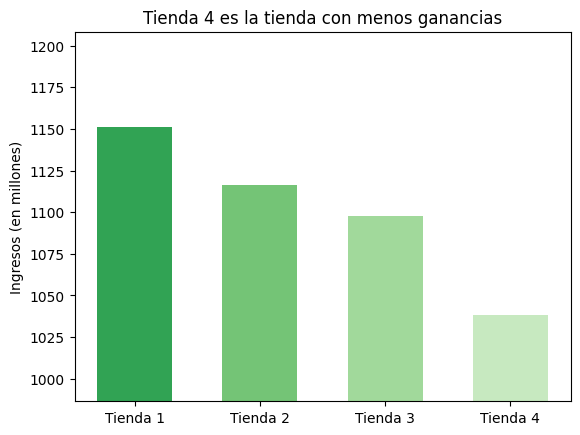

In [5]:
def graph1() -> None:
    x = [f'Tienda {idx+1}' for idx in range(len(tiendas))]
    y = list(map(lambda p: p/1e6, precios))
    # x.reverse(); y.reverse()

    lim_sup = tope(y)
    lim_inf = tope(y, False)

    color = plt.get_cmap('tab20c')(range(8, 12))

    fig = plt.bar(x, y, color=color, width=.6)
    # plt.plot(x, y, 'o', linestyle='--', color='xkcd:light purple', )

    plt.title('Tienda 4 es la tienda con menos ganancias')
    plt.ylabel('Ingresos (en millones)')
    plt.ylim(lim_inf*.95, lim_sup*1.05)
    plt.show()


graph1()

# 2. Ventas por categoría

In [6]:
def ventas_cat(df) -> pd.Series:
    return (df.groupby('Categoría del Producto')
            .count()['Producto']
            .rename('# Ventas')
            .sort_values(ascending=False))


cat_tiendas: list[pd.Series] = list(map(ventas_cat, tiendas))

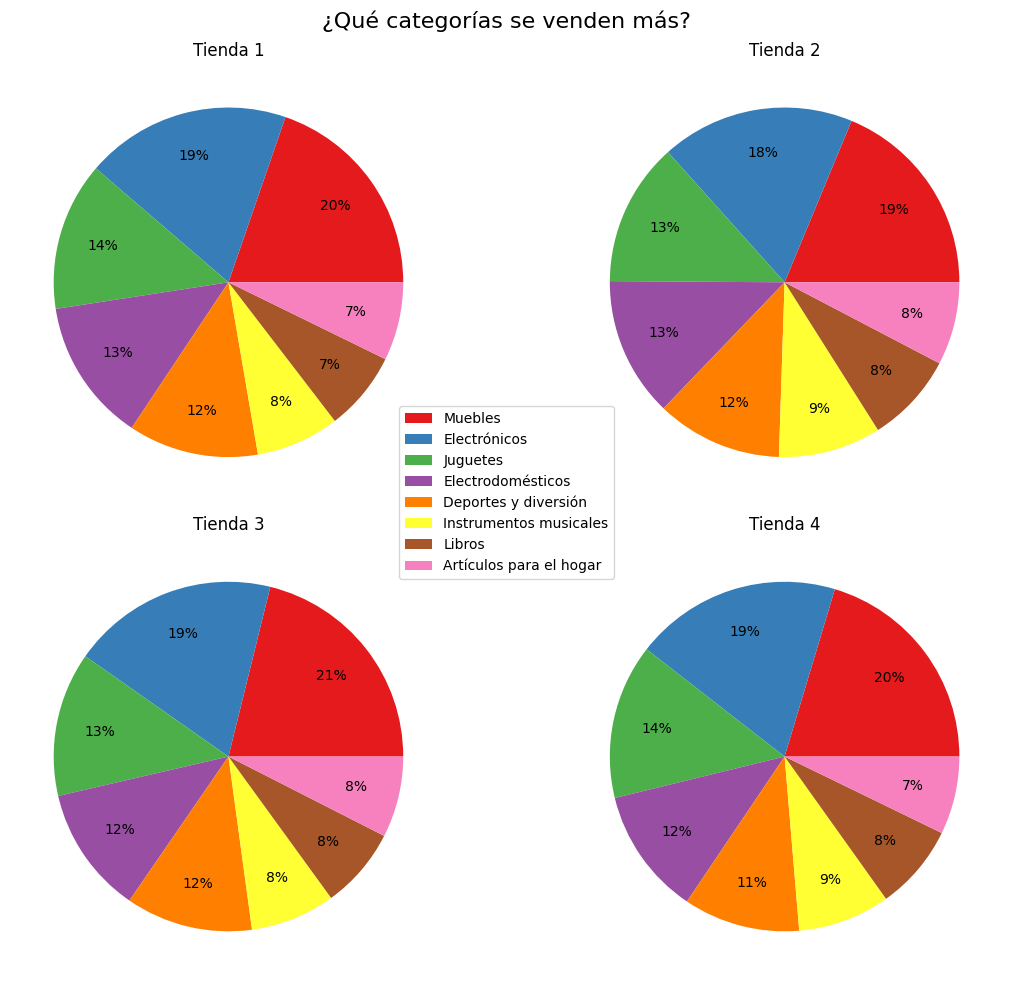

In [7]:
def graph2() -> None:
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    plt.suptitle('¿Qué categorías se venden más?', fontsize=16)

    for idx in range(len(cat_tiendas)):
        i = 0 if idx < 2 else 1
        j = 0 if idx % 2 == 0 else 1

        ax[i,j].set_title(tiendas_s[idx])
        ax[i,j].pie(
            cat_tiendas[idx].values,
            labels=None,
            colors=plt.get_cmap('Set1').colors,
            autopct='%1.0f%%',
            pctdistance=.75
        )

    fig.legend(cat_tiendas[0].index, loc='center')
    plt.tight_layout()
    plt.show()


graph2()

# 3. Calificación promedio de la tienda


In [8]:
calificaciones: list[float] = list(map(lambda df: df['Calificación'].mean(), tiendas))

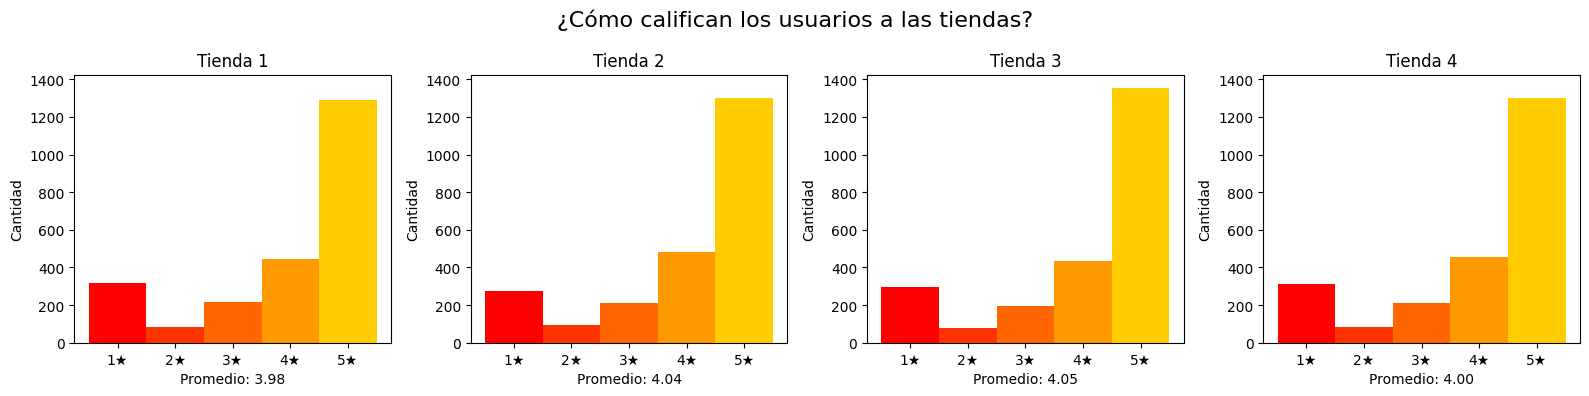

In [9]:
def graph3() -> None:
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle('¿Cómo califican los usuarios a las tiendas?', fontsize=16)

    conteos = list(map(
        lambda df: df.groupby('Calificación').count().sort_values('Calificación', ascending=False)['Producto'],
        tiendas
    ))
    cant_max = tope(conteos)

    # Colores
    nums = list(conteos[0].index)[::-1]
    n = list(map(lambda x: x/len(nums), nums))
    color = plt.get_cmap('autumn_r')(n)

    ticks = list(map(lambda x: str(x) + '★', nums))

    for idx in range(len(calificaciones)):
        ax[idx].bar(conteos[idx].index, conteos[idx].values, width=1, color=color)
        ax[idx].set_title(tiendas_s[idx])

        # ax[idx].bar_label(b, label_type='edge')
        ax[idx].set_ylim(0, cant_max * 1.05)

        ax[idx].set_xlabel(f'Promedio: {calificaciones[idx]:.2f}')
        ax[idx].set_ylabel('Cantidad')

        ax[idx].set_xticks(nums)
        ax[idx].set_xticklabels(ticks)

    plt.tight_layout()
    plt.show()


graph3()

# 4. Productos más y menos vendidos

In [10]:
def top(df, asc=False) -> pd.Series:
    return (df.groupby('Producto')
            .count()['Precio']
            .rename('Vendidos')
            .sort_values(ascending=asc)
            .head(4))


mas_vendidos:   list[pd.Series] = list(map(lambda df: top(df), tiendas))
menos_vendidos: list[pd.Series] = list(map(lambda df: top(df, True), tiendas))

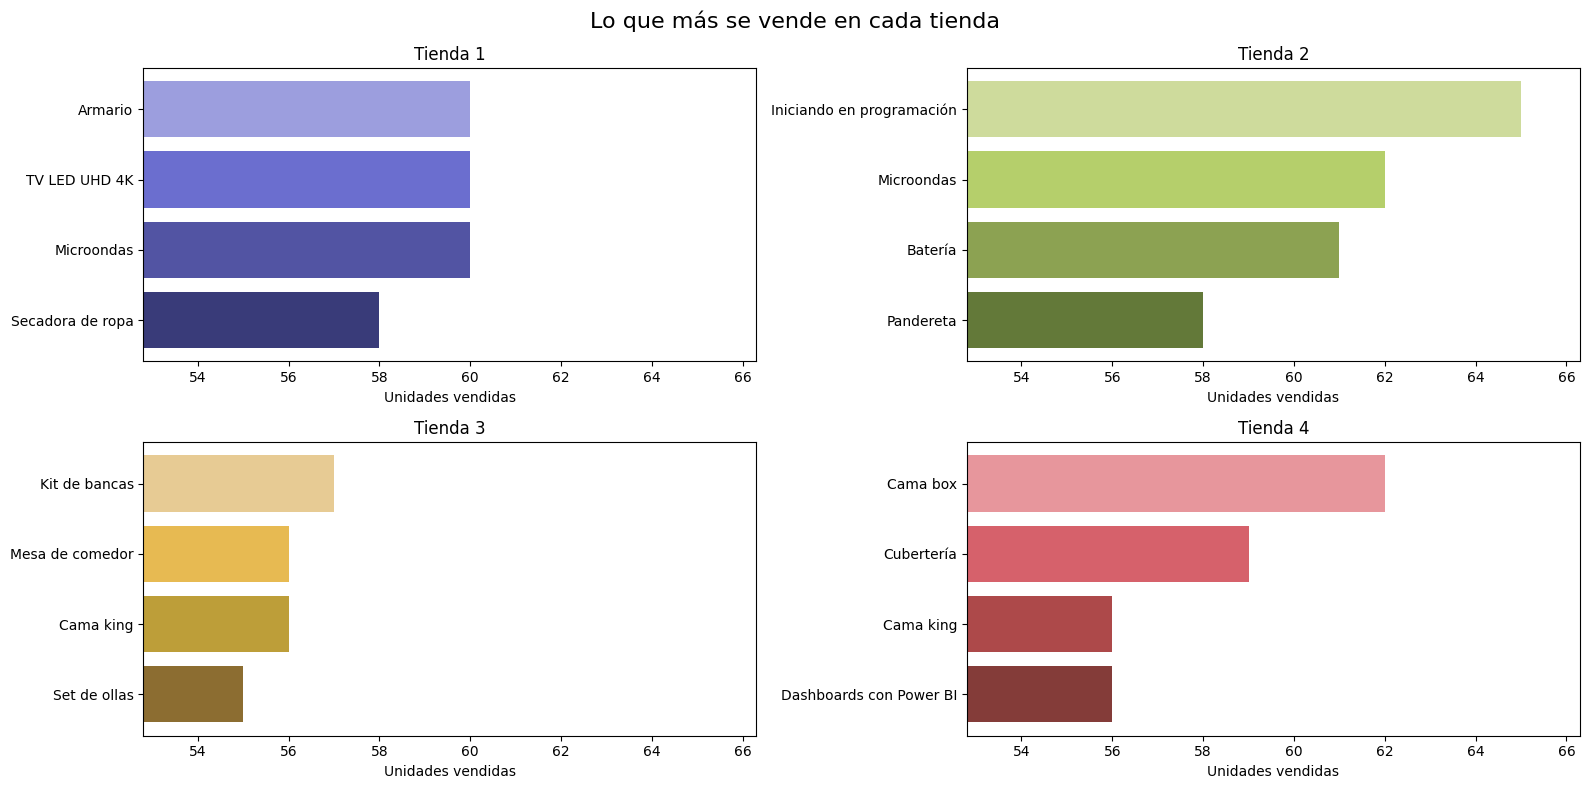

In [11]:
def graph4(lista, superior=True) -> None:
    # Colormaps
    # productos = pd.concat(lista).index
    # nums = [idx for idx, _ in enumerate(productos.unique())]
    # norm = list(map(lambda x: x/productos.nunique(), nums))
    # color = plt.get_cmap('hsv')(norm)
    # prod_color = {productos.unique()[idx]: color[idx] for idx in range(productos.nunique())}

    fig, ax = plt.subplots(2, 2, figsize=(16, 8))
    titulo = 'Lo que más se vende en cada tienda' if superior else 'Los productos menos adquiridos en las tiendas'
    fig.suptitle(titulo, fontsize=16)

    lim_sup = tope(lista)
    lim_inf = tope(lista, False)

    for idx in range(len(lista)):
        i = 0 if idx < 2 else 1
        j = 0 if idx % 2 == 0 else 1

        ax[i,j].set_title(tiendas_s[idx])
        ax[i,j].set_xlim(lim_inf * .96, lim_sup * 1.02)
        ax[i,j].set_xlabel('Unidades vendidas')
        ax[i,j].invert_yaxis()

        lista_productos = lista[idx]
        color = plt.get_cmap('tab20b')(range(idx*4, (idx+1)*4))

        if superior:
            color = color[::-1]
        ax[i,j].barh(lista_productos.index, lista_productos.values, color=color)

        # Colormaps
        # for n, vendidos in enumerate(_prods):
        #     ax[i,j].barh(_prods.index[n], vendidos, color=prod_color[_prods.index[n]])

    plt.tight_layout()
    plt.show()

graph4(mas_vendidos)

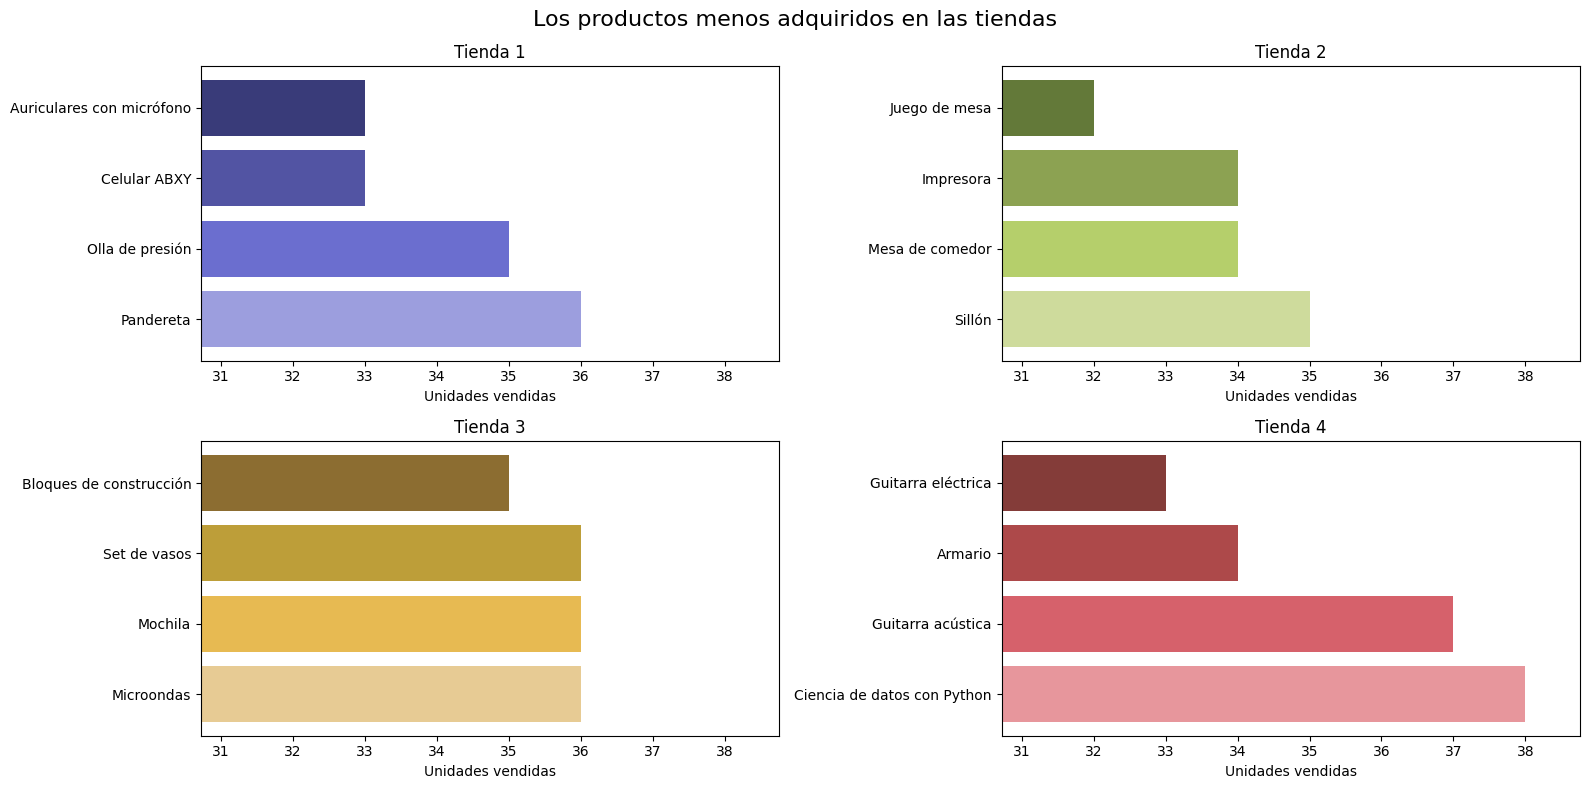

In [12]:
graph4(menos_vendidos, False)

# 5. Envío promedio por tienda

In [13]:
promedios: list[pd.Series] = list(map(lambda df: df['Costo de envío'].mean(), tiendas))

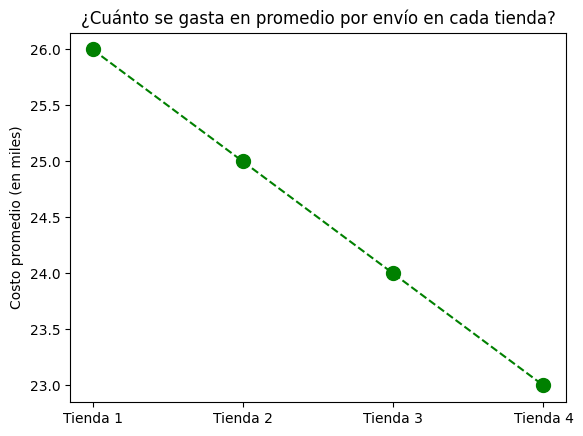

In [14]:
def graph5() -> None:
    x = tiendas_s
    y = list(map(lambda f: int(f/1e3), promedios))

    plt.title('¿Cuánto se gasta en promedio por envío en cada tienda?')
    plt.plot(x, y, 'go--', markersize=10)
    plt.tick_params(axis='y')
    plt.ylabel('Costo promedio (en miles)')
    plt.show()


graph5()

# Extra: Análisis del desempeño geográfico